# Disgregacion de grupos

In [4]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

def calcular_ratios_por_estacion(estacion, carpeta="listos"):
    """
    Calcula los ratios Rotíferos / Copépodos / Cladóceros
    para cada laguna dentro de una estación climática.
    """
    ruta = os.path.join(carpeta, f"{estacion}.csv")
    df = pd.read_csv(ruta)

    grupo_cols = ["Rotiferos", "Copepodos", "Cladoceros"]
    lagunas = [c for c in df.select_dtypes(include=[np.number]).columns if c not in grupo_cols]

    resultados = []
    for laguna in lagunas:
        total = df[laguna].sum()
        if total == 0:
            rot = cop = cla = np.nan
        else:
            rot = df.loc[df["Rotiferos"] == 1, laguna].sum() / total
            cop = df.loc[df["Copepodos"] == 1, laguna].sum() / total
            cla = df.loc[df["Cladoceros"] == 1, laguna].sum() / total

        resultados.append({
            "Estacion": estacion,
            "Laguna": laguna,
            "Rotiferos": rot,
            "Copepodos": cop,
            "Cladoceros": cla
        })

    return pd.DataFrame(resultados)


def resumen_ratios_general(carpeta="listos"):
    """
    Itera sobre las estaciones, calcula ratios y promedia por laguna base (L1,C,L2).
    Devuelve un DataFrame con ratios promedio por laguna y estación.
    """
    estaciones = ["invierno", "verano", "otoño", "primavera"]
    df_final = pd.DataFrame()

    for e in estaciones:
        df_ratios = calcular_ratios_por_estacion(e, carpeta)

        # Crear columna 'Laguna_base' (nombre antes del espacio)
        df_ratios["Laguna_base"] = df_ratios["Laguna"].str.split().str[0]

        # Promedio de los tres puntos (L1, C, L2)
        df_mean = (
            df_ratios
            .groupby(["Estacion", "Laguna_base"], as_index=False)
            [["Rotiferos", "Copepodos", "Cladoceros"]]
            .mean()
        )

        df_final = pd.concat([df_final, df_mean], ignore_index=True)

    return df_final


In [5]:
# -----------------------------
# Ejecutar el flujo completo
# -----------------------------
df_ratios_final = resumen_ratios_general("listos")

# Guardar resultado
df_ratios_final.to_csv("ratios_zooplancton_por_laguna_y_estacion.csv", index=False)

print("✅ Archivo generado: ratios_zooplancton_por_laguna_y_estacion.csv")
df_ratios_final.head(5)

✅ Archivo generado: ratios_zooplancton_por_laguna_y_estacion.csv


,Estacion,Laguna_base,Rotiferos,Copepodos,Cladoceros
0,invierno,Crespo,1.000000,0.000000,0.000000
1,invierno,Espinillo,0.824000,0.016393,0.159606
2,invierno,Gazano,0.997339,0.002661,0.000000
3,invierno,Hernandez,0.904063,0.077374,0.018563
4,invierno,Inta,0.581541,0.369375,0.049084


In [6]:
hfi = {"Inta":6.83,
       "Hernandez":3.11,
       "Viale":5.09,
       "Crespo":7.32,
       "Espinillo": 4.42,
       "Termas":5.69,
       "Gazano": 6.93
       }

df_ratios_final["HFI"] = df_ratios_final["Laguna_base"].map(hfi)
df =df_ratios_final

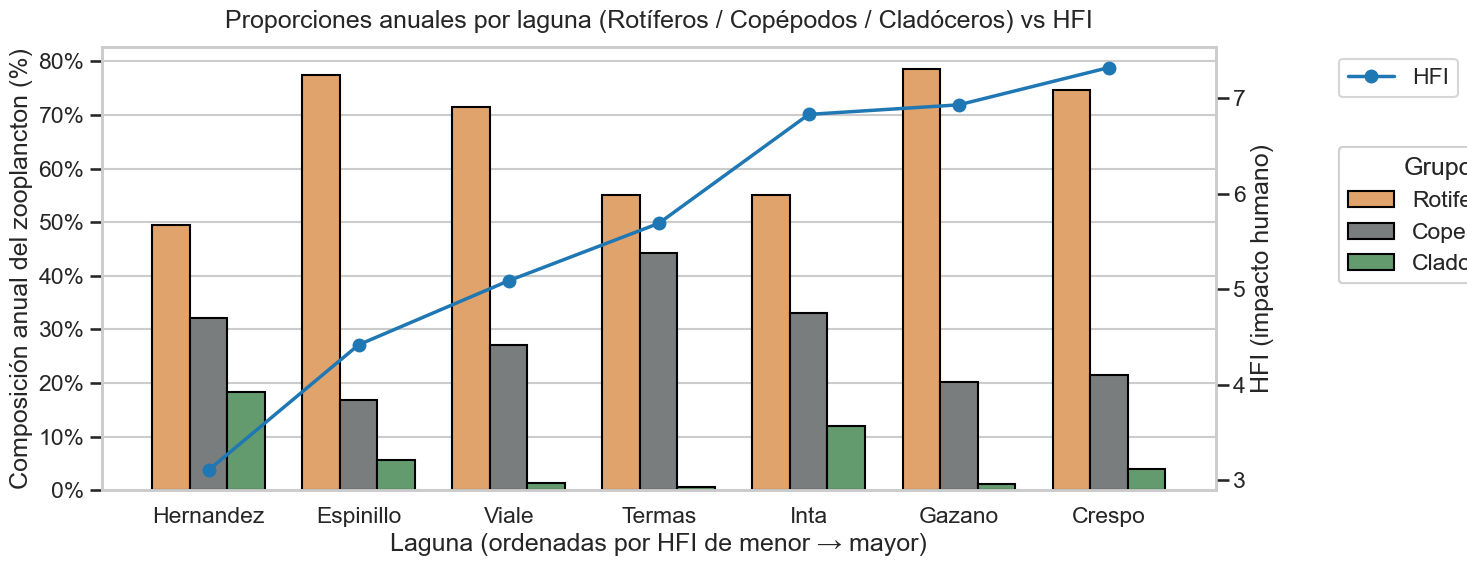

In [7]:
annual = (
    df.groupby("Laguna_base", as_index=False)
      .agg({
          "Rotiferos": "mean",
          "Copepodos": "mean",
          "Cladoceros": "mean",
          "HFI": "mean"   # si HFI es anual fijo, da igual mean/first
      })
)

# Orden por HFI
annual = annual.sort_values("HFI", ascending=True).reset_index(drop=True)

# Long para barras (triadas)
annual_long = annual.melt(
    id_vars=["Laguna_base", "HFI"],
    value_vars=["Rotiferos", "Copepodos", "Cladoceros"],
    var_name="Grupo",
    value_name="Proporcion"
)

# --- 2) Gráfico: barras agrupadas + HFI en eje secundario ---
sns.set(style="whitegrid", context="talk")

fig, ax = plt.subplots(figsize=(18,6))

hue_order = ["Rotiferos", "Copepodos", "Cladoceros"]
palette   = {"Rotiferos":"#f4a259", "Copepodos":"#7a7d7d", "Cladoceros":"#5aa469"}

# Barras (triadas por laguna)
bars = sns.barplot(
    data=annual_long,
    x="Laguna_base", y="Proporcion", hue="Grupo",
    hue_order=hue_order, palette=palette,
    errorbar=None, edgecolor="black", width=0.75, ax=ax
)

# Formato porcentual para proporciones
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{100*v:.0f}%"))
ax.set_ylabel("Composición anual del zooplancton (%)")
ax.set_xlabel("Laguna (ordenadas por HFI de menor → mayor)")
plt.setp(ax.get_xticklabels(), rotation=0)

# Eje secundario para HFI (línea + puntos)
ax2 = ax.twinx()
xpos = np.arange(len(annual))  # posiciones de categorías
ax2.plot(xpos, annual["HFI"], marker="o", linewidth=2.5, color="#1f77b4", label="HFI")
ax2.set_ylabel("HFI (impacto humano)")
ax2.grid(False)

# Alinear ticks del eje x con las categorías
ax.set_xticks(xpos)
ax.set_xticklabels(annual["Laguna_base"])

# Leyendas: combinamos barras (hue) + línea HFI
handles1, labels1 = ax.get_legend_handles_labels()
leg2 = ax2.legend([leg for leg in ax2.lines], ["HFI"], loc="upper left", bbox_to_anchor=(1.10, 1))
leg1 = ax.legend(handles1, labels1, title="Grupo", loc="upper left", bbox_to_anchor=(1.10, 0.8))
ax.add_artist(leg1)  # asegurar que quede la de barras

plt.title("Proporciones anuales por laguna (Rotíferos / Copépodos / Cladóceros) vs HFI", pad=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # deja más espacio a la derecha
plt.savefig("ratios.png")
plt.show()


In [8]:
df

,Estacion,Laguna_base,Rotiferos,Copepodos,Cladoceros,HFI
0,invierno,Crespo,1.000000,0.000000,0.000000,7.32
1,invierno,Espinillo,0.824000,0.016393,0.159606,4.42
2,invierno,Gazano,0.997339,0.002661,0.000000,6.93
3,invierno,Hernandez,0.904063,0.077374,0.018563,3.11
4,invierno,Inta,0.581541,0.369375,0.049084,6.83
5,invierno,Termas,0.474805,0.513290,0.011905,5.69
6,invierno,Viale,0.942386,0.022443,0.035171,5.09
7,verano,Crespo,0.493943,0.499032,0.007025,7.32
8,verano,Espinillo,0.826668,0.166006,0.007326,4.42
9,verano,Gazano,0.926575,0.073425,0.000000,6.93


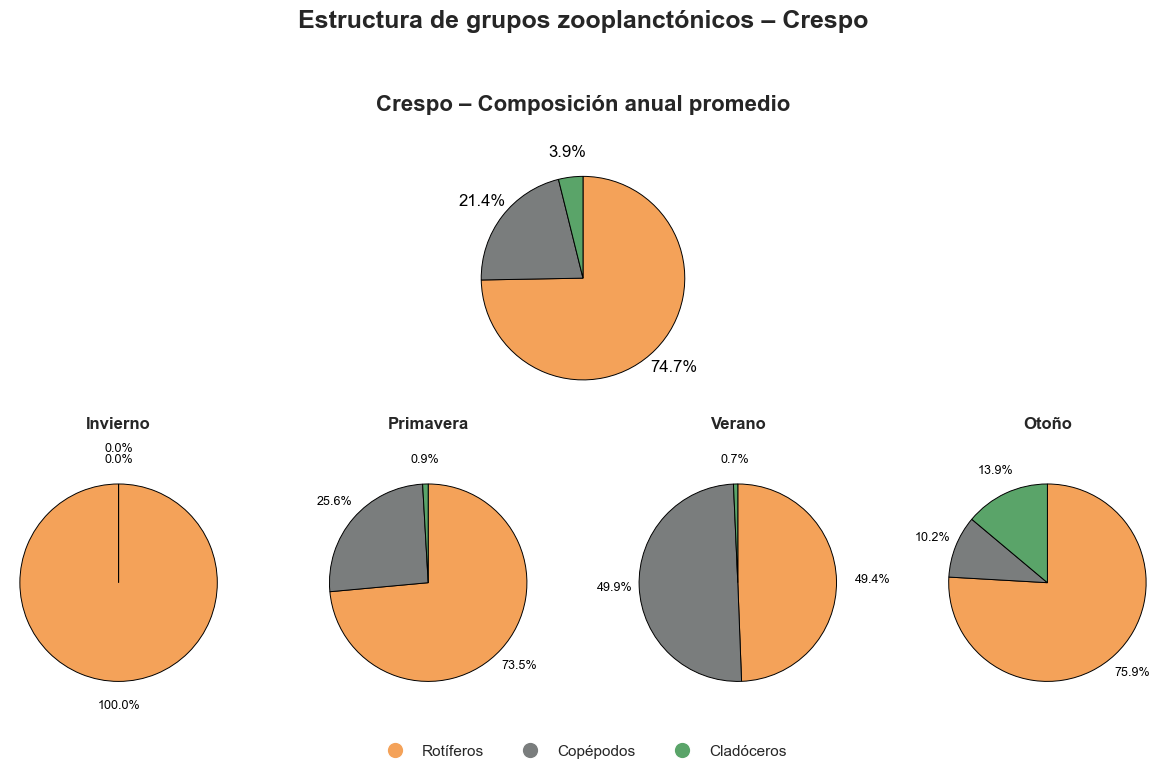

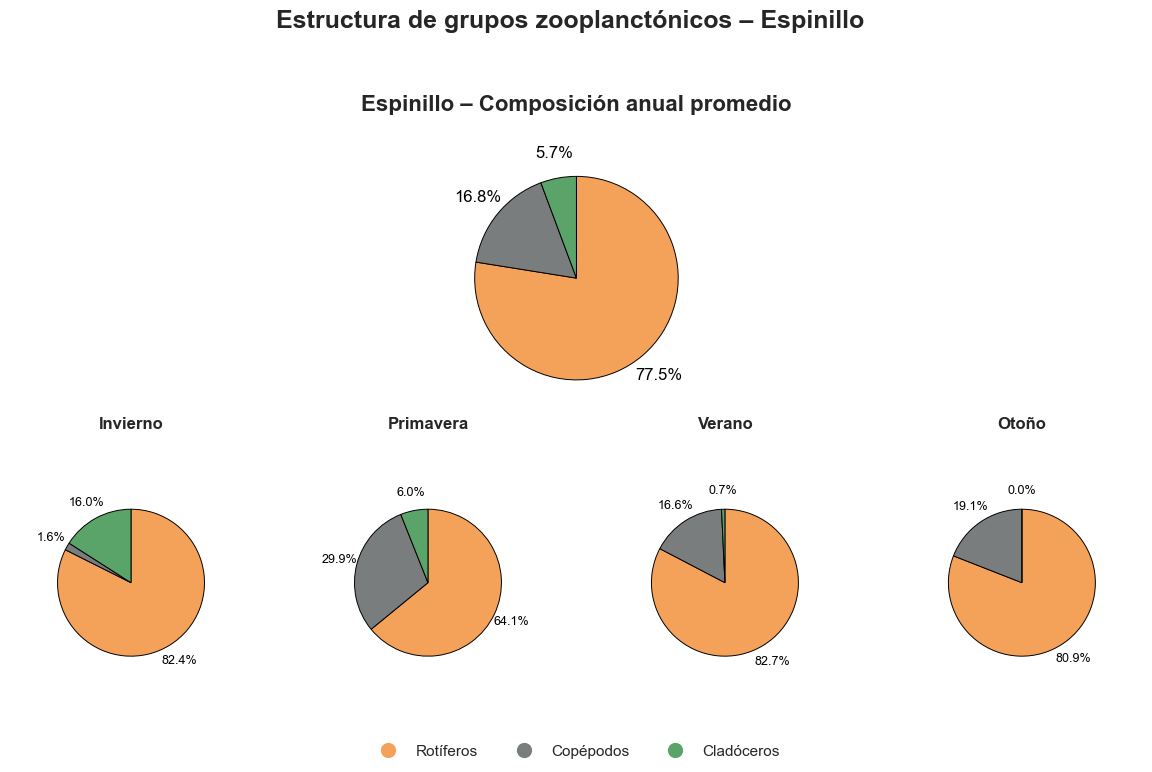

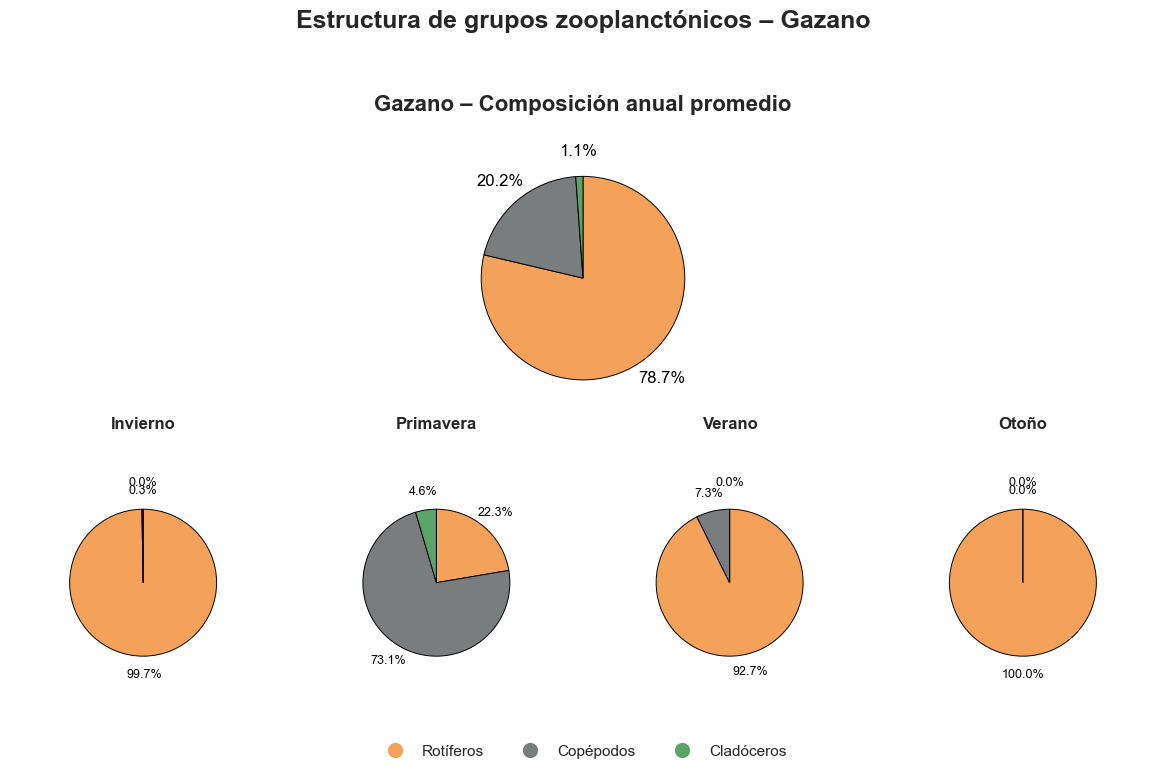

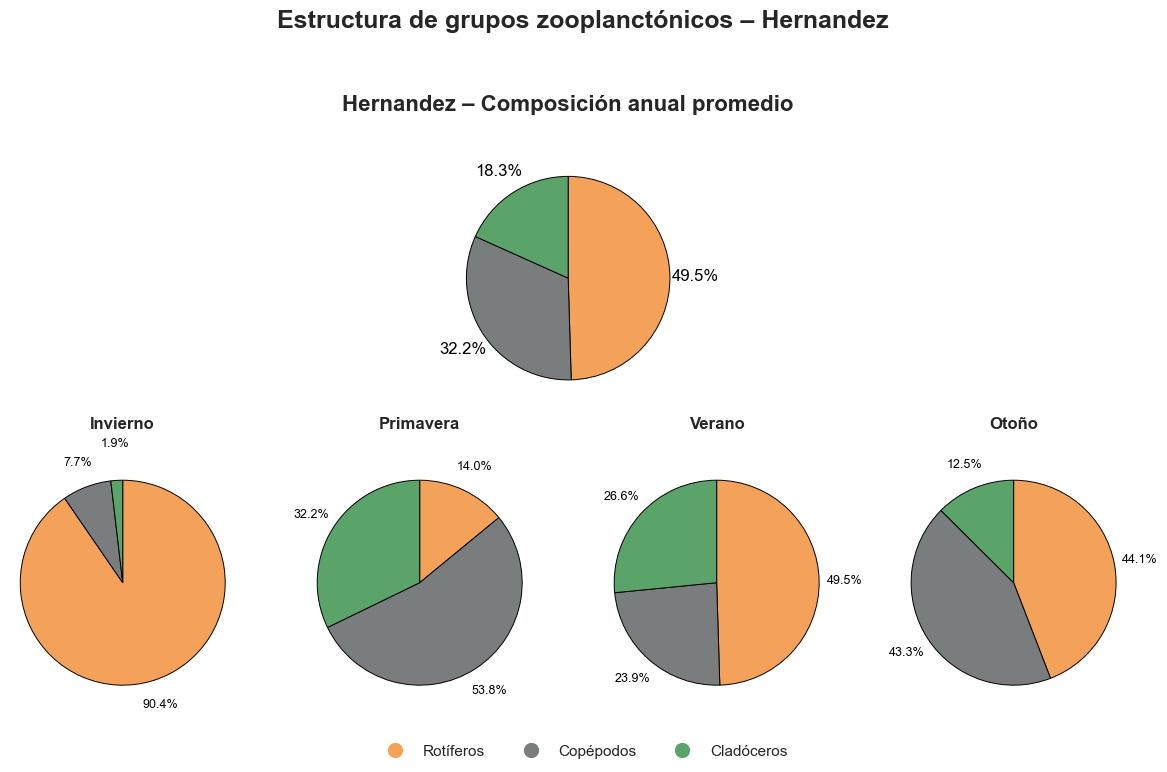

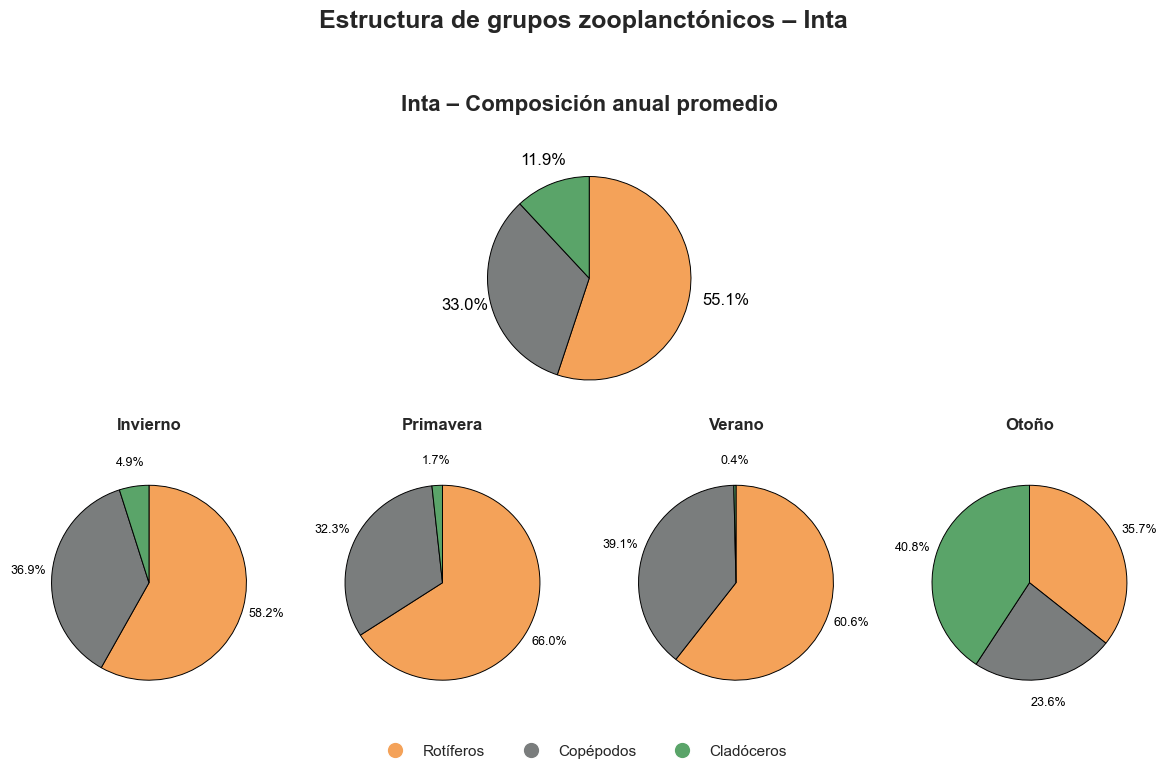

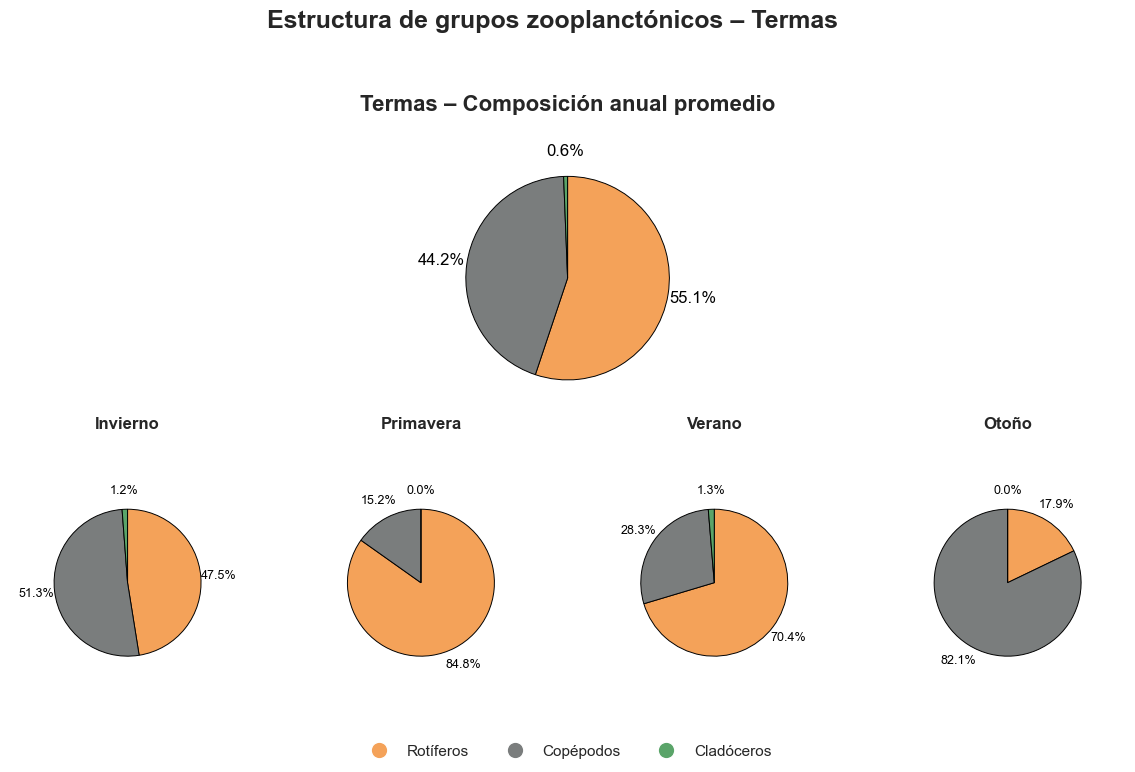

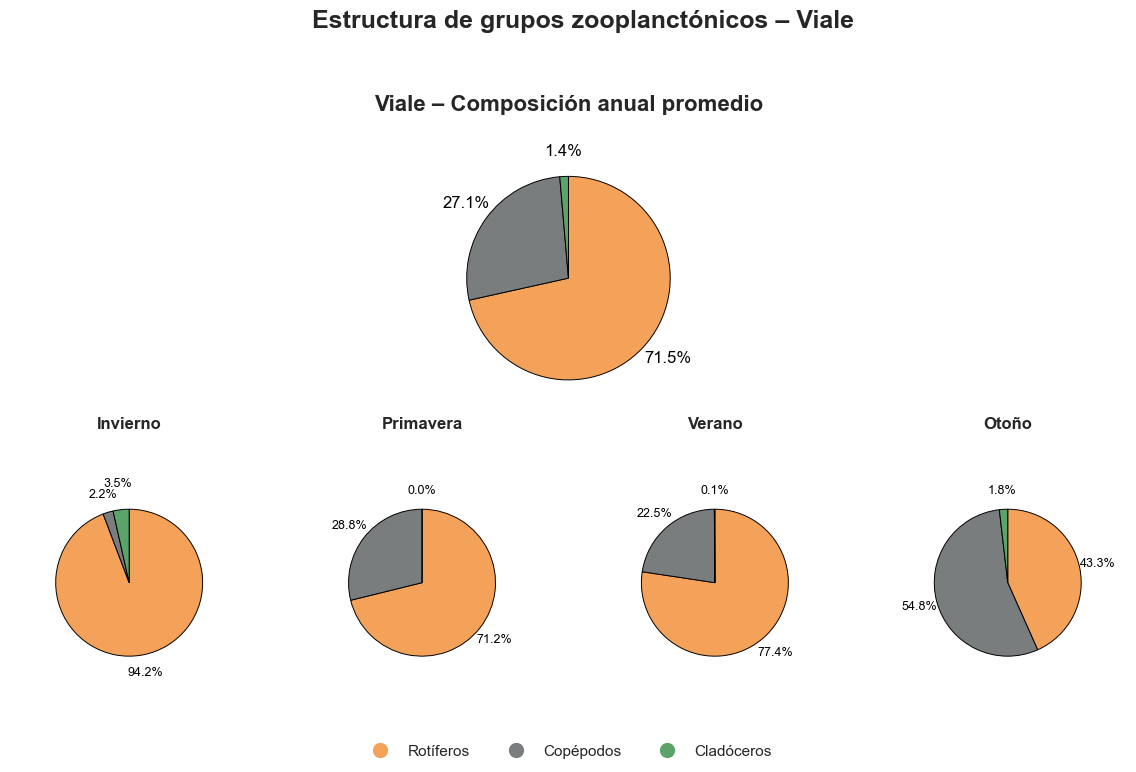

In [16]:
sns.set(style="whitegrid", context="talk")

# Orden de estaciones
orden_estaciones = ["invierno", "primavera", "verano", "otoño"]
df["Estacion"] = pd.Categorical(df["Estacion"], categories=orden_estaciones, ordered=True)

grupos = ["Rotiferos", "Copepodos", "Cladoceros"]
palette = {
    "Rotiferos":  "#f4a259",
    "Copepodos":  "#7a7d7d",
    "Cladoceros": "#5aa469"
}

# ---------------------------------------------------
# FUNCIÓN: pie con borde negro y % por fuera (con de-overlap simple)
# ---------------------------------------------------
def pie_outside(ax, values, colors, pct_fs=10, r_pct=1.25,radius=1.0):
    """
    Pie chart con:
      - borde negro
      - porcentajes fuera del círculo
      - pequeño ajuste para que no se encimen las etiquetas
    """
    vals = np.asarray(values, dtype=float)
    if np.isclose(np.nansum(vals), 0):
        ax.text(0.5, 0.5, "Sin abundancia", ha="center", va="center", fontsize=9)
        ax.axis("on")
        return

    wedges, texts, autotexts = ax.pie(
        vals,
        labels=None,
        colors=colors,
        startangle=90,
        counterclock=False,
        autopct="%1.1f%%",
        pctdistance=0.7,
        wedgeprops={"edgecolor": "black", "linewidth": 0.7}
    )

    # Limpio posibles labels internos
    for t in texts:
        t.set_text("")

    # 1) Colocamos % hacia afuera
    positions = []
    for w, t in zip(wedges, autotexts):
        ang = (w.theta2 + w.theta1) / 2.0
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        px, py = r_pct * x, r_pct * y
        t.set_position((px, py))
        t.set_fontsize(pct_fs)
        t.set_color("black")
        t.set_ha("center")
        t.set_va("center")
        positions.append([px, py])

    # 2) De-overlap muy simple: si dos % están demasiado cerca en Y,
    #    empujo uno un poquito más afuera.
    positions = np.array(positions)
    min_dy = 0.1  # distancia mínima vertical (ajustable)

    # ordeno por coordenada y (para comparar vecinos)
    order = np.argsort(positions[:, 1])
    for i in range(1, len(order)):
        idx_prev = order[i - 1]
        idx_curr = order[i]
        y_prev = positions[idx_prev, 1]
        y_curr = positions[idx_curr, 1]

        if abs(y_curr - y_prev) < min_dy:
            # empujo el actual un poco más afuera en la misma dirección
            x0, y0 = positions[idx_curr]
            factor = 1.09  # cuánto lo separo (ajustable)
            positions[idx_curr] = [x0 * factor, y0 * factor]
            autotexts[idx_curr].set_position((positions[idx_curr, 0], positions[idx_curr, 1]))

    ax.axis("equal")


# ---------------------------------------------------
# LOOP PRINCIPAL – una figura por laguna
# ---------------------------------------------------
lagunas = sorted(df["Laguna_base"].unique())

for lag in lagunas:
    sub = df[df["Laguna_base"] == lag].copy()
    annual_vals = sub[grupos].mean()

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 4, height_ratios=[2, 2])

    # --- Pie anual ---
    ax_annual = fig.add_subplot(gs[0, :])
    pie_outside(
        ax=ax_annual,
        values=annual_vals.values,
        colors=[palette[g] for g in grupos],
        pct_fs=12,
        r_pct=1.25,
        radius=5
    )
    ax_annual.set_title(
        f"{lag} – Composición anual promedio",
        fontsize=16,
        pad=40,           # ← distancia entre el gráfico y ESTE título
        fontweight="bold"
    )

    # --- Pies por estación ---
    axes_season = [fig.add_subplot(gs[1, i]) for i in range(4)]

    for ax, est in zip(axes_season, orden_estaciones):
        sub_est = sub[sub["Estacion"] == est]
        if sub_est.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center", fontsize=9)
            ax.axis("off")
            continue

        vals = sub_est[grupos].iloc[0]
        pie_outside(
            ax=ax,
            values=vals.values,
            colors=[palette[g] for g in grupos],
            pct_fs=9,
            r_pct=1.25,
            radius=0.2
        )
        ax.set_title(est.capitalize(), fontsize=12, fontweight="bold",pad=30)

    # --- Leyenda global ---
    handles = [
        plt.Line2D([0], [0], marker="o", color="w",
                   markerfacecolor=palette[g], markersize=12, label=g)
        for g in grupos
    ]
    fig.legend(
        handles,
        ["Rotíferos", "Copépodos", "Cladóceros"],
        loc="lower center",
        ncol=3,
        fontsize=11,
        frameon=False
    )

    # --- Supertítulo (título de toda la figura) ---
    fig.suptitle(
        f"Estructura de grupos zooplanctónicos – {lag}",
        fontsize=18,
        y=0.95,           # ← altura del título principal
        fontweight="bold"
    )

    # Separación general del layout
    plt.tight_layout(rect=[0, 0.06, 1, 0.94])
    plt.savefig("charts.png")
    plt.show()
